In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_brk'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0026041666666666665
FEMALE 0.9975 

GLOBAL: 0.48358585858585856 

Using scikit learn accuracy por género en el conjunto to
MALE 0.004866180048661801
FEMALE 1.0 

GLOBAL: 0.485006518904824 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0025252525252525255
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931440040001886 	 Validation loss: 0.690898378016585 	 
  1%|          | 574/57400 [00:06<08:57, 105.81it/s]
Epoch 2 	 Training loss: 0.6884570075036757 	 Validation loss: 0.6877429455013598 	 
  2%|▏         | 1148/57400 [00:12<09:22, 100.02it/s]
Epoch 3 	 Training loss: 0.6855890392634096 	 Validation loss: 0.6862001025070579 	 
  3%|▎         | 1722/57400 [00:17<09:03, 102.44it/s]
Epoch 4 	 Training loss: 0.6838714667313606 	 Validation loss: 0.685105277320086 	 
  4%|▍         | 2296/57400 [00:23<08:48, 104.17it/s]
Epoch 5 	 Training loss: 0.6828118127605226 	 Validation loss: 0.6845242461915744 	 
  5%|▌         | 2870/57400 [00:29<08:33, 106.15it/s]
Epoch 6 	 Training loss: 0.682194772601543 	 Validation loss: 0.684134710643251 	 
  6%|▌         | 3444/57400 [00:35<08:52, 101.38it/s]
Epoch 7 	 Training loss: 0.6818615788989781 	 Validation loss: 0.6841733344530655 	 
  7%|▋         | 4018/57400 [00:41<08:35, 103.47it/s]
Epoch 8 	 Training loss: 0.68160

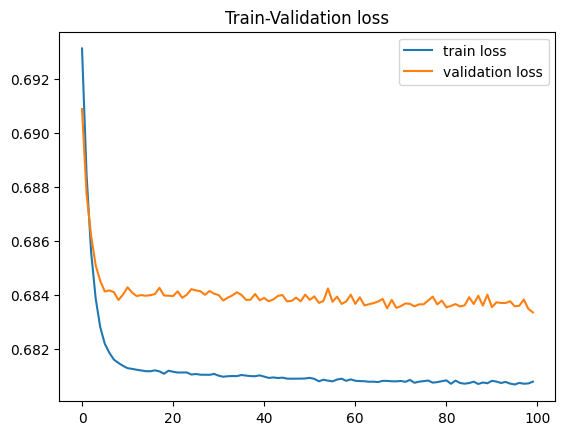

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_brk'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693282962468443 	 Validation loss: 0.6934744129746647 	 
  1%|          | 574/57400 [00:05<08:02, 117.71it/s]
Epoch 2 	 Training loss: 0.693160701088789 	 Validation loss: 0.693308044288118 	 
  2%|▏         | 1148/57400 [00:10<08:02, 116.56it/s]
Epoch 3 	 Training loss: 0.6931930610111782 	 Validation loss: 0.6929676088236146 	 
  3%|▎         | 1722/57400 [00:16<07:50, 118.22it/s]
Epoch 4 	 Training loss: 0.6931125243366387 	 Validation loss: 0.6929640769958496 	 
  4%|▍         | 2296/57400 [00:21<07:52, 116.69it/s]
Epoch 5 	 Training loss: 0.6931295300402293 	 Validation loss: 0.6929276484554097 	 
  5%|▌         | 2870/57400 [00:26<07:46, 116.98it/s]
Epoch 6 	 Training loss: 0.6931760164711118 	 Validation loss: 0.6929015315185159 	 
  6%|▌         | 3444/57400 [00:32<07:43, 116.34it/s]
Epoch 7 	 Training loss: 0.6931613473942055 	 Validation loss: 0.6928818832009526 	 
  7%|▋         | 4018/57400 [00:37<07:40, 115.80it/s]
Epoch 8 	 Training loss: 0.6931

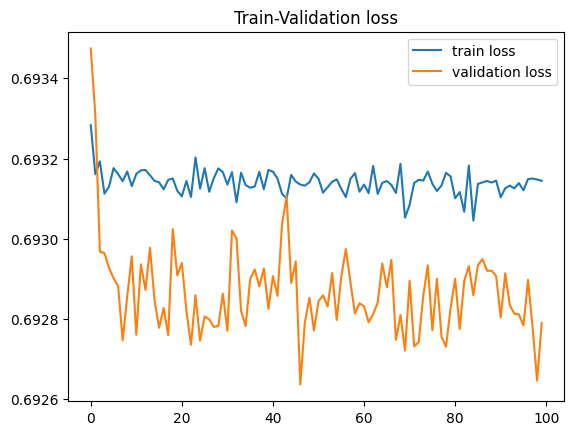

In [22]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5025510204081632 

Using scikit learn accuracy por género en el conjunto about
MALE 0.2109375
FEMALE 0.7825 

GLOBAL: 0.4898989898989899 

Using scikit learn accuracy por género en el conjunto to
MALE 0.19464720194647203
FEMALE 0.8083989501312336 

GLOBAL: 0.4954367666232073 

Using scikit learn accuracy por género en el conjunto as
MALE 0.17676767676767677
FEMALE 0.8355795148247979 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_brk'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934348725898756 	 Validation loss: 0.6927384188619711 	 
  1%|          | 574/57400 [00:05<08:04, 117.36it/s]
Epoch 2 	 Training loss: 0.6932767363790852 	 Validation loss: 0.6925609313835532 	 
  2%|▏         | 1148/57400 [00:10<08:00, 117.16it/s]
Epoch 3 	 Training loss: 0.6932688349215411 	 Validation loss: 0.692753647343587 	 
  3%|▎         | 1722/57400 [00:16<07:59, 116.20it/s]
Epoch 4 	 Training loss: 0.693207143802676 	 Validation loss: 0.6924507183543707 	 
  4%|▍         | 2296/57400 [00:21<07:55, 115.78it/s]
Epoch 5 	 Training loss: 0.6931685770014853 	 Validation loss: 0.6928744002924128 	 
  5%|▌         | 2870/57400 [00:26<07:48, 116.47it/s]
Epoch 6 	 Training loss: 0.6932308295877968 	 Validation loss: 0.6929967777203705 	 
  6%|▌         | 3444/57400 [00:32<07:58, 112.75it/s]
Epoch 7 	 Training loss: 0.6932085074406468 	 Validation loss: 0.6932207709651882 	 
  7%|▋         | 4018/57400 [00:37<07:41, 115.66it/s]
Epoch 8 	 Training loss: 0.693

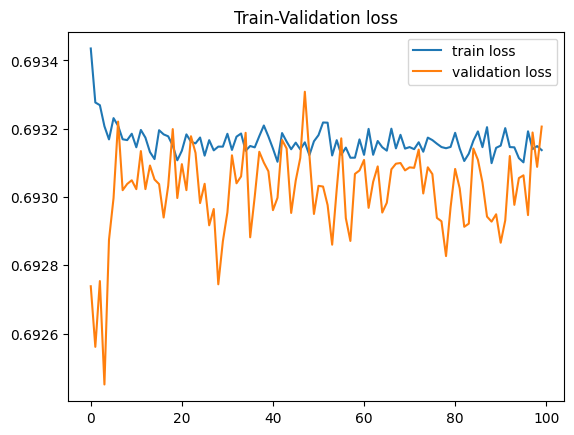

In [25]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5012755102040817 

Using scikit learn accuracy por género en el conjunto about
MALE 0.10416666666666667
FEMALE 0.8825 

GLOBAL: 0.4861111111111111 

Using scikit learn accuracy por género en el conjunto to
MALE 0.12652068126520682
FEMALE 0.8740157480314961 

GLOBAL: 0.4784876140808344 

Using scikit learn accuracy por género en el conjunto as
MALE 0.08585858585858586
FEMALE 0.8975741239892183 



# ADAM

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_brk_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6799264029966414 	 Validation loss: 0.6798002184447596 	 
  1%|          | 574/57400 [00:05<08:16, 114.55it/s]
Epoch 2 	 Training loss: 0.6648666768331561 	 Validation loss: 0.656034263513856 	 
  2%|▏         | 1148/57400 [00:10<08:08, 115.23it/s]
Epoch 3 	 Training loss: 0.6490241329636723 	 Validation loss: 0.6455996541653649 	 
  3%|▎         | 1722/57400 [00:16<08:03, 115.10it/s]
Epoch 4 	 Training loss: 0.6396532204093003 	 Validation loss: 0.6383225735971483 	 
  4%|▍         | 2296/57400 [00:21<08:14, 111.53it/s]
Epoch 5 	 Training loss: 0.6312981895868787 	 Validation loss: 0.6295170662766796 	 
  5%|▌         | 2870/57400 [00:27<08:06, 112.12it/s]
Epoch 6 	 Training loss: 0.6227582887282355 	 Validation loss: 0.6223587989807129 	 
  6%|▌         | 3444/57400 [00:32<07:56, 113.12it/s]
Epoch 7 	 Training loss: 0.613739725189342 	 Validation loss: 0.6148344207618196 	 
  7%|▋         | 4018/57400 [00:38<07:52, 112.95it/s]
Epoch 8 	 Training loss: 0.604

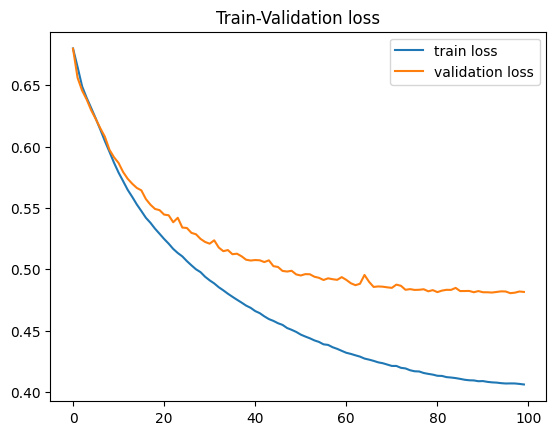

In [28]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [29]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7232142857142857 

Using scikit learn accuracy por género en el conjunto about
MALE 0.78125
FEMALE 0.6675 

GLOBAL: 0.5972222222222222 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6520681265206812
FEMALE 0.5380577427821522 

GLOBAL: 0.6101694915254238 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6161616161616161
FEMALE 0.6037735849056604 



# TO

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_brk_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933127653100349 	 Validation loss: 0.6925845125974235 	 
  1%|          | 574/57400 [00:06<09:15, 102.21it/s]
Epoch 2 	 Training loss: 0.6932735002830054 	 Validation loss: 0.69325725506928 	 
  2%|▏         | 1148/57400 [00:12<09:06, 102.88it/s]
Epoch 3 	 Training loss: 0.6931576970769968 	 Validation loss: 0.6935510271686619 	 
  3%|▎         | 1722/57400 [00:18<09:01, 102.80it/s]
Epoch 4 	 Training loss: 0.6931365838449591 	 Validation loss: 0.6932334384675753 	 
  4%|▍         | 2296/57400 [00:24<09:07, 100.73it/s]
Epoch 5 	 Training loss: 0.6929763345768227 	 Validation loss: 0.6927757253081112 	 
  5%|▌         | 2870/57400 [00:30<08:48, 103.11it/s]
Epoch 6 	 Training loss: 0.6930757980105768 	 Validation loss: 0.6929794630761874 	 
  6%|▌         | 3444/57400 [00:36<08:45, 102.67it/s]
Epoch 7 	 Training loss: 0.6930464703446897 	 Validation loss: 0.694390240362135 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:42<08:33, 103.98it/s]
Ep

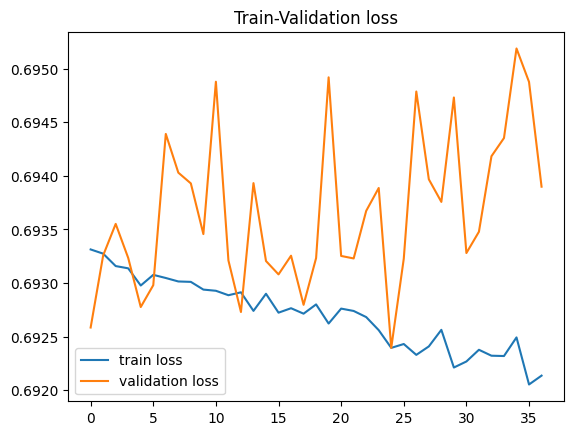

In [31]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [32]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5025510204081632 

Using scikit learn accuracy por género en el conjunto about
MALE 0.2526041666666667
FEMALE 0.7425 

GLOBAL: 0.4911616161616162 

Using scikit learn accuracy por género en el conjunto to
MALE 0.24817518248175183
FEMALE 0.7532808398950132 

GLOBAL: 0.4745762711864407 

Using scikit learn accuracy por género en el conjunto as
MALE 0.2196969696969697
FEMALE 0.7466307277628033 



# AS

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_brk_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933309497110519 	 Validation loss: 0.6939016671504005 	 
  1%|          | 574/57400 [00:06<09:12, 102.83it/s]
Epoch 2 	 Training loss: 0.6932100438697828 	 Validation loss: 0.6932864108328092 	 
  2%|▏         | 1148/57400 [00:12<09:28, 98.93it/s]
Epoch 3 	 Training loss: 0.6931396599222974 	 Validation loss: 0.6923076884221222 	 
  3%|▎         | 1722/57400 [00:18<09:44, 95.23it/s]
Epoch 4 	 Training loss: 0.6930429450518578 	 Validation loss: 0.6922814643989175 	 
  4%|▍         | 2296/57400 [00:25<09:18, 98.73it/s]
Epoch 5 	 Training loss: 0.6930351721492793 	 Validation loss: 0.6932021510803094 	 
  5%|▌         | 2870/57400 [00:31<09:02, 100.57it/s]
Epoch 6 	 Training loss: 0.6929821595289981 	 Validation loss: 0.6926601407891613 	 
  6%|▌         | 3444/57400 [00:37<08:55, 100.68it/s]
Epoch 7 	 Training loss: 0.6930141164450695 	 Validation loss: 0.693855844311795 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:43<08:54, 99.80it/s]
Epoc

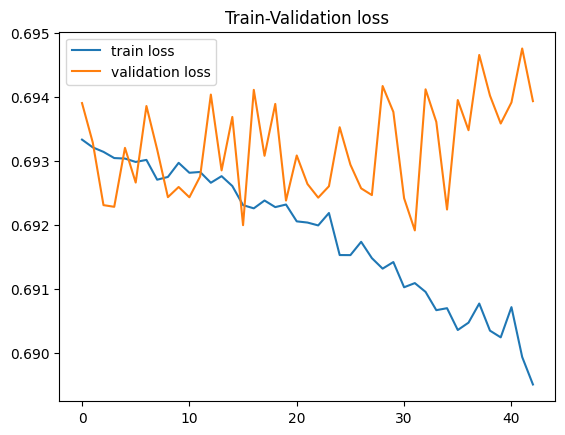

In [34]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [35]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.514030612244898 

Using scikit learn accuracy por género en el conjunto about
MALE 0.4140625
FEMALE 0.61 

GLOBAL: 0.4898989898989899 

Using scikit learn accuracy por género en el conjunto to
MALE 0.44768856447688565
FEMALE 0.5354330708661418 

GLOBAL: 0.4784876140808344 

Using scikit learn accuracy por género en el conjunto as
MALE 0.4090909090909091
FEMALE 0.5525606469002695 

